# IMPORTING LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# IMPORTING DATASET FROM KAGGLE

In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle


In [4]:
!cp kaggle.json ~/.kaggle

In [5]:
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d odins0n/ucf-crime-dataset


100% 11.0G/11.0G [02:13<00:00, 150MB/s]
100% 11.0G/11.0G [02:13<00:00, 88.8MB/s]


In [7]:
!unzip ucf-crime-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/Vandalism/Vandalism035_x264_230.png  
  inflating: Train/Vandalism/Vandalism035_x264_240.png  
  inflating: Train/Vandalism/Vandalism035_x264_250.png  
  inflating: Train/Vandalism/Vandalism035_x264_260.png  
  inflating: Train/Vandalism/Vandalism035_x264_270.png  
  inflating: Train/Vandalism/Vandalism035_x264_280.png  
  inflating: Train/Vandalism/Vandalism035_x264_290.png  
  inflating: Train/Vandalism/Vandalism035_x264_30.png  
  inflating: Train/Vandalism/Vandalism035_x264_300.png  
  inflating: Train/Vandalism/Vandalism035_x264_310.png  
  inflating: Train/Vandalism/Vandalism035_x264_320.png  
  inflating: Train/Vandalism/Vandalism035_x264_330.png  
  inflating: Train/Vandalism/Vandalism035_x264_340.png  
  inflating: Train/Vandalism/Vandalism035_x264_350.png  
  inflating: Train/Vandalism/Vandalism035_x264_360.png  
  inflating: Train/Vandalism/Vandalism035_x264_370.png  
  inflating: Train/Vandalism/Vandalism

# TRAINING AND TESTING DATA SEPERATION

In [8]:
train_dir = "/content/Train"
test_dir = "/content/Test"
SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 128
EPOCHS = 5
LR = 0.00003
crime_types=os.listdir(train_dir)
n=len(crime_types)
print("Number of crime categories : ",n)

Number of crime categories :  14


# DATAVISUALIZATION OF THE DATASET

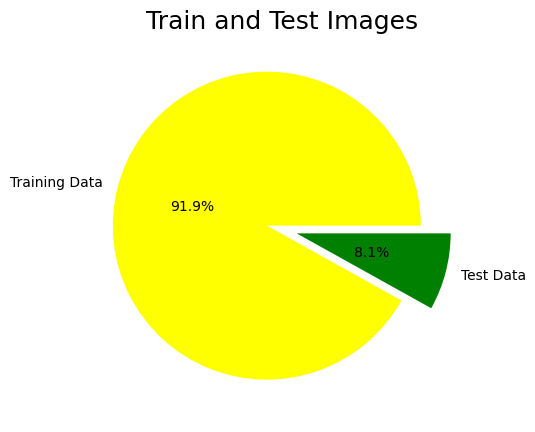

In [9]:
crimes={}
train=test=0
for clss in crime_types:
    num=len(os.listdir (os.path.join(train_dir,clss)))
    train+=num
    test+=len(os.listdir (os.path.join(test_dir,clss)))
    crimes[clss]=num


plt.figure(figsize=(8, 5))
plt.pie(x=np.array([train, test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5,colors=["yellow", "green"])
plt.title("Train and Test Images", fontsize=18);

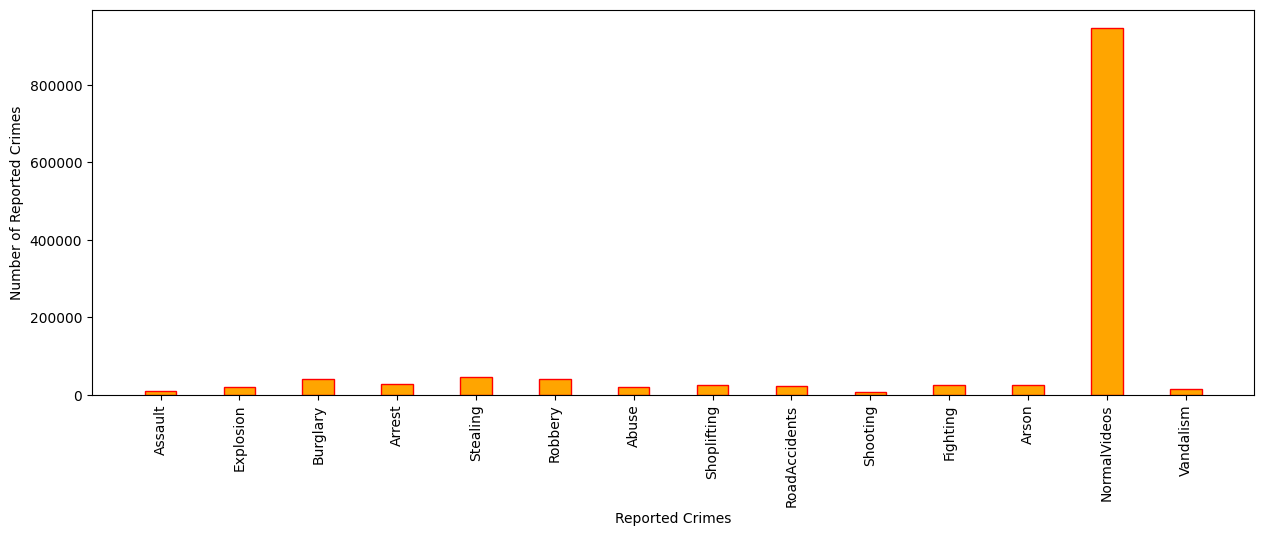

In [10]:
plt.figure(figsize=(15,5))
plt.bar(list(crimes.keys()), list (crimes.values()), width=0.4, align="center",edgecolor=["red"],color=["orange"])
plt.xticks(rotation=90)


plt.xlabel("Reported Crimes")
plt.ylabel("Number of Reported Crimes")
plt.show()


# TRAIN SET ,TEST SET AND VAL SET

In [11]:
IMG_SHAPE=(64,64)
#Apply Image_Dataset_from_directory Functionality To Train Set And Test Set
train_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training",
)



val_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=SEED,
    validation_split =0.2,
    subset="validation",
)


test_set=image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=SEED,
)


Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.
Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.
Found 111308 files belonging to 14 classes.


# Create Transfer Learning Function

In [13]:
# Create Transfer Learning Function
INPUT_SHAPE=(64,64,3)
def transfer_learning():
    base_model=DenseNet121(include_top=False, input_shape=INPUT_SHAPE, weights="imagenet")

    thr=149

    for layers in base_model.layers[:thr]:
        layers.trainable=False

    for layers in base_model.layers[thr:]:
        layers.trainable=False

    return base_model




model=create_model()

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Adding Dense Layers

In [ ]:
# Adding Dense Layers

def create_model():
    model=Sequential()

    base_model=transfer_learning()
    model.add(base_model)

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.2))

    model.add(Dense(512, activation="relu"))
    model.add(Dropout (0.2))

    model.add(Dense(1024, activation="relu"))

    model.add(Dense (n, activation="softmax"))

    model.summary()

    return model


In [14]:
# Configure The Learning Process

model=create_model()

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 dense_7 (Dense)             (None, 14)                14350     
                                                      

# Train the model

In [ ]:
# Train The Model
history = model.fit(x = train_set,
                    validation_data=val_set,
                    epochs = 5)

#Saving the model


In [ ]:
# Save model
model.save('crime.h5')

#Load the saved model using load_model

In [16]:
#Load the saved model using load_model

from tensorflow.keras.models import load_model
model=load_model('crime.h5')

In [17]:
model.load_weights('crime.h5')

#y_prediction


In [18]:
y_true = np.array([])
for x, y in test_set:
    y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])


y_pred=model.predict(test_set)

870/870 [==============================] - 1038s 1s/step


#Testing

In [ ]:
from tensorflow.keras.preprocessing import image

# Testing 1
img = image.load_img("/content/Test/Burglary/Burglary005_x264_1030.png",target_size=(64,64)) # Reading image
x = image.img_to_array(img) # Converting Image into array
x = np.expand_dims(x,axis=0) # expanding Dimensions
pred = np.argmax (model.predict(x)) # Predicting the higher probablity Index
op = ['Fighthing', 'Arrest', 'Vandalism', 'Assault', 'Stealing' , 'Arson', 'Normalvideos', 'Burglary', 'Explosion', 'Robbery','Abuse', 'shooting', 'Shoplifting', 'RoadAccident']
op[pred] # tist indexing with output

1/1 [==============================] - 0s 40ms/step


'Burglary'

In [ ]:
# Testing 2
img = image.load_img("/content/Test/Fighting/Fighting003_x264_1020.png",target_size=(64,64)) # Reading image
x = image.img_to_array(img) # Converting Image into array
x = np.expand_dims(x,axis=0) # expanding Dimensions
pred = np.argmax (model.predict(x)) # Predicting the higher probablity Index
op = ['Fighthing', 'Arrest', 'Vandalism', 'Assault', 'Stealing' , 'Arson', 'Normalvideos', 'Burglary', 'Explosion', 'Robbery','Abuse', 'shooting', 'Shoplifting', 'RoadAccident']
op[pred] # tist indexing with output

1/1 [==============================] - 0s 41ms/step


'Robbery'